In [14]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
class MaxFactorization:
    def __init__(self, Y, K, lam=0.1, X = None, W=None, learning_rate=0.5, max_iter=1000, print_every=100, user_based = 1):
        self.Y_raw = Y
        self.K = K
        self.lam = lam
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.print_every = print_every
        self.user_based = user_based
        self.n_users =1390
        self.n_items = 8352
        self.n_ratings = Y.shape[0]

        if X is None:
            self.X = np.random.randn(self.n_items, K)
        else:
            self.X = X
        
        if W is None:
            self.W =np.random.randn(K, self.n_users)
        else:
            self.W = W
        
        self.Y_normalize = self.Y_raw.copy()
    
    def normalize_Y(self):
        if self.user_based:
            user_col = 0
            item_col = 1
            n_objects = self.n_users
        else:
            user_col = 1
            item_col = 0
            n_objects = self.n_items
        
        users = self.Y_raw[:, user_col]
        self.mean_users = np.zeros((n_objects,))

        for user in range(n_objects):
            ids = np.where(users == user)[0].astype(np.int32)
            item_ids = self.Y_normalize[ids, item_col]
            ratings = self.Y_normalize[ids, 2]

            m = np.mean(ratings)

            if np.isnan(m):
                m = 0
            self.mean_users[user] = m

            self.Y_normalize[ids, 2] = ratings - self.mean_users[user]
        

    def loss(self):
        L = 0
        for i in range(self.n_ratings):
            user, item, rating = [int(self.Y_normalize[i, 0]), int(self.Y_normalize[i, 1]), int(self.Y_normalize[i, 2])]
            L += 0.5 * (rating - self.X[item, :].dot(self.W[:, user])) ** 2
        
        L /= self.n_ratings

        L += 0.5*self.lam*(np.linalg.norm(self.X, 'fro') + np.linalg.norm(self.W, 'fro'))
        return L



    def get_items_rated_by_user(self, user_id):
        ids = np.where(self.Y_normalize[:, 0] == user_id)[0]
        item_ids = self.Y_normalize[ids, 1].astype(np.int32)
        ratings = self.Y_normalize[ids, 2]
        return (item_ids, ratings)
    
    def get_users_who_rate_item(self, item_id):
        ids = np.where(self.Y_normalize[:, 1] == item_id)[0]
        user_ids = self.Y_normalize[ids, 0].astype(np.int32)
        ratings = self.Y_normalize[ids, 2]
        return (user_ids, ratings)
    
    def updateX(self):
        for item in range(self.n_items):
            user_ids, ratings = self.get_users_who_rate_item(item)
            W_item = self.W[:, user_ids]

            grad_x = -(ratings - self.X[item, :].dot(W_item)).dot(W_item.T) / self.n_ratings + \
                self.lam * self.X[item, :]
            self.X[item, :] -= self.learning_rate * grad_x.reshape((self.K,))

    def updateW(self):
        for user in range(self.n_users): 
            item_ids, ratings = self.get_items_rated_by_user(user)
            X_user = self.X[item_ids, :]

            grad_w = -X_user.T.dot(ratings - X_user.dot(self.W[:, user])) / self.n_ratings + \
                self.lam * self.W[:, user]
            
            self.W[:, user] -= self.learning_rate*grad_w.reshape((self.K, ))
    
    def fit(self):
        self.normalize_Y()
        for it in range(self.max_iter):
            self.updateX()
            self.updateW()
            if (it + 1) % self.print_every == 0:
                rmse_train = self.evaluate_RMSE(self.Y_raw)
                print('iter =', it + 1, ', loss =', self.loss(), ', RMSE train =', rmse_train)
            
    def pred(self, u, i):
        u = int(u)
        i = int(i)

        if self.user_based:
            bias = self.mean_users[u]
        else:
            bias = self.mean_users[i]


        pred = self.X[i, :].dot(self.W[:, u]) +  bias   

        if pred < 0:
            return 0
        if pred > 5:
            return 5
        return pred
    
    def pred_for_user(self, user_id):
        ids = np.where(self.Y_normalize[:, 0] == user_id)[0]
        items_rated_by_u = self.Y_normalize[ids, 1].tolist()
        y_pred = self.X.dot(self.W[:, user_id]) + self.mean_users[user_id]
        
        predicted_ratings = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                predicted_ratings.append((i, y_pred[i]))
        
        return predicted_ratings
    
    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            SE += (pred - rate_test[n, 2]) ** 2
        
        RMSE = np.sqrt(SE/n_tests)
        return RMSE
    def pred_all(self, rate_test):
        res = []
        test = []
        n_tests = rate_test.shape[0]
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            res.append(pred)
            test.append(rate_test[n, 2])
        return [res, test]

In [8]:
class Metrics():
    def computeMSE(y_true, y_pred):
        return np.mean((y_true-y_pred)**2)

    def computeMAE(y_true, y_pred):
        return np.mean(np.abs(y_true-y_pred))

    def computeSIA(y_true, y_pred, eps=1): 
        error = np.abs(y_true - y_pred)
        bina = 0
        for err in error:
            if (err <= eps):
                bina += 1
        return bina/len(y_true)

In [9]:
avg_mae_tests = []
avg_mse_tests = []
avg_rmse_tests = []
avg_sia_1_tests = []
avg_sia_0_5_tests = []
avg_sia_0_25_tests = []

avg_mae_trains = []
avg_mse_trains = []
avg_rmse_trains = []
avg_sia_1_trains = []
avg_sia_0_5_trains = []
avg_sia_0_25_trains = []

In [ ]:
learning_rates = [0.1, 0.25, 0.5, 0.75, 1, 2]

for rate in tqdm(learning_rates):

    avg_mae_test = 0
    avg_mse_test = 0
    avg_rmse_test = 0
    avg_sia_1_test = 0
    avg_sia_0_5_test = 0
    avg_sia_0_25_test = 0

    avg_mae_train = 0
    avg_mse_train = 0
    avg_rmse_train = 0
    avg_sia_1_train = 0
    avg_sia_0_5_train = 0
    avg_sia_0_25_train = 0

    for i in range(1, 6):
        train_path = f'../../data/datasets/rating/kfold/u{i}.base.csv'
        test_path = f'../../data/datasets/rating/kfold/u{i}.test.csv'
        rate_train = pd.read_csv(train_path, sep=',', encoding='latin-1')[['user index', 'movie index', 'rating']].drop_duplicates(subset=['user index', 'movie index'], keep='first').values
        rate_test = pd.read_csv(test_path, sep=',', encoding='latin-1')[['user index', 'movie index', 'rating']].drop_duplicates(subset=['user index', 'movie index'], keep='first').values
    
        rs = MaxFactorization(rate_train, K = 10, lam=0.5, print_every=10, learning_rate=rate, max_iter=100, user_based=1)
        rs.fit()
        Y_predict_test, Y_true_test = rs.pred_all(rate_test)
        Y_predict_test = np.array(Y_predict_test)
        Y_true_test = np.array(Y_true_test)

        Y_predict_train, Y_true_train = rs.pred_all(rate_train)
        Y_predict_train = np.array(Y_predict_train)
        Y_true_train = np.array(Y_true_train)

        #Compute RMSE metrics
        RMSE = rs.evaluate_RMSE(rate_test)
        avg_rmse_test += RMSE

        #Compute MAE metrics
        mae_test = Metrics.computeMAE(Y_true_test, Y_predict_test)
        avg_mae_test += mae_test

        #Compute MSE metrics
        mse_test = Metrics.computeMSE(Y_true_test, Y_predict_test)
        avg_mse_test += mse_test

        #Compute SIA metrics
        sia_test_1 = Metrics.computeSIA(Y_true_test, Y_predict_test, 1)
        avg_sia_1_test += sia_test_1

        sia_test_0_5 = Metrics.computeSIA(Y_true_test, Y_predict_test, 0.5)
        avg_sia_0_5_test += sia_test_0_5

        sia_test_0_25 = Metrics.computeSIA(Y_true_test, Y_predict_test, 0.25)
        avg_sia_0_25_test += sia_test_0_25


        #Compute RMSE metrics
        RMSE = rs.evaluate_RMSE(rate_train)
        avg_rmse_train += RMSE

        #Compute MAE metrics
        mae_train = Metrics.computeMAE(Y_true_train, Y_predict_train)
        avg_mae_train += mae_train

        #Compute MSE metrics
        mse_train = Metrics.computeMSE(Y_true_train, Y_predict_train)
        avg_mse_train += mse_train

        #Compute SIA metrics
        sia_train_1 = Metrics.computeSIA(Y_true_train, Y_predict_train, 1)
        avg_sia_1_train += sia_train_1

        sia_train_0_5 = Metrics.computeSIA(Y_true_train, Y_predict_train, 0.5)
        avg_sia_0_5_train += sia_train_0_5

        sia_train_0_25 = Metrics.computeSIA(Y_true_train, Y_predict_train, 0.25)
        avg_sia_0_25_train += sia_train_0_25

    avg_mae_trains.append(avg_mae_train / 5)
    avg_mse_trains.append(avg_mse_train / 5)
    avg_sia_1_trains.append(avg_sia_1_train / 5)
    avg_sia_0_5_trains.append(avg_sia_0_5_train / 5)
    avg_sia_0_25_trains.append(avg_sia_0_25_train / 5)

    avg_mae_tests.append(avg_mae_test / 5)
    avg_mse_tests.append(avg_mse_test / 5)
    avg_sia_1_tests.append(avg_sia_1_test / 5)
    avg_sia_0_5_tests.append(avg_sia_0_5_test / 5)
    avg_sia_0_25_tests.append(avg_sia_0_25_test / 5)

In [16]:
X = [0.1, 0.25, 0.5, 0.75, 1, 2]

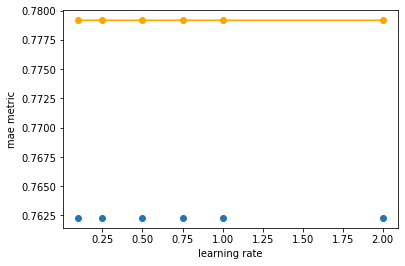

In [35]:
plt.scatter(X, avg_mae_trains)
plt.plot(X, avg_mae_tests, color="orange", marker="o")
plt.xlabel("learning rate")
plt.ylabel("mae metric")
plt.savefig('../../result/images/MF/learning_rate/mae.png')

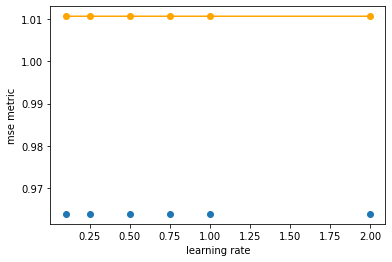

In [34]:
plt.scatter(X, avg_mse_trains)
plt.plot(X, avg_mse_tests, color="orange", marker="o")
plt.xlabel("learning rate")
plt.savefig('../../result/images/MF/learning_rate/mse.png')

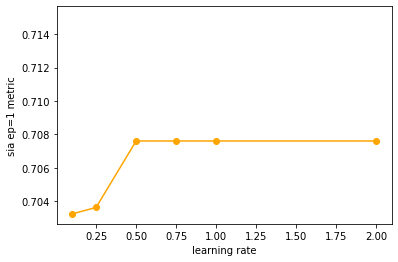

In [33]:
plt.scatter(X, avg_sia_1_trains, c=[])
plt.plot(X, avg_sia_1_tests, color="orange", marker="o")
plt.xlabel("learning rate")
plt.ylabel("sia ep=1 metric")
plt.savefig('../../result/images/MF/learning_rate/sia_1.png')

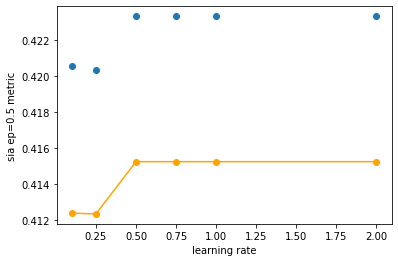

In [32]:
plt.scatter(X, avg_sia_0_5_trains)
plt.plot(X, avg_sia_0_5_tests, color="orange", marker="o")
plt.xlabel("learning rate")
plt.ylabel("sia ep=0.5 metric")
plt.savefig('../../result/images/MF/learning_rate/sia_0_5.png')

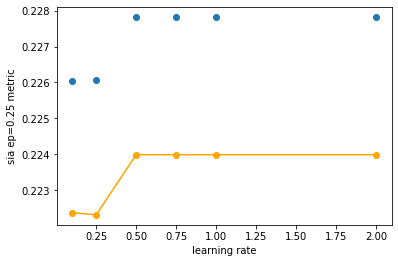

In [31]:
plt.scatter(X, avg_sia_0_25_trains)
plt.plot(X, avg_sia_0_25_tests, color="orange", marker="o")
plt.xlabel("learning rate")
plt.ylabel("sia ep=0.25 metric")
plt.savefig('../../result/images/MF/learning_rate/sia_0_25.png')